In [18]:
from collections import Counter
import warnings
warnings.filterwarnings(action='ignore')

import numpy as np
import pandas as pd
from pandas.api.types import is_numeric_dtype
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
%matplotlib inline

from sklearn import svm

plt.rcParams["figure.figsize"] = (10, 10)
plt.rcParams["font.family"] = 'NanumGothicCoding'

from visualize import plot_confusion_matrix

In [19]:
df = pd.read_csv('Data_M_2.csv')
df = df.drop(['pid',
              'Type',
             'recent_by',
             'own_sedan',
             'own_suv',
             'own_ice',
             'own_zev',
             'oldest_car',
             ],
             axis='columns')
print(df.shape)
df.head()

(4128, 33)


,policy,eco,tech,age,gender,owning,mileage,family,job,wealth,...,Car3_fuel_type,Car3_car_class,Car3_infra,Car3_fuel_cost,Car3_price,Car3_old,p_infra,p_class,p_fuel_cost,p_price
0,3,3,2,31,1,1,10000,3,3,7,...,0,0,0,0,0,0,50,1,50,4000
1,3,3,2,31,1,1,10000,3,3,7,...,0,0,0,0,0,0,100,1,50,5000
2,3,3,2,31,1,1,10000,3,3,7,...,0,0,0,0,0,0,100,1,150,5000
3,3,3,2,31,1,1,10000,3,3,7,...,0,0,0,0,0,0,100,1,50,2000
4,3,3,2,31,1,1,10000,3,3,7,...,0,0,0,0,0,0,50,2,50,5000


In [20]:
NUMERICAL_COLUMNS = [
    'policy',
    'eco',
    'tech',
    'age',
    'owning',
    'mileage',
    'family',
    'wealth',
    
    'p_infra',
    'p_class',
    'p_fuel_cost',
    'p_price',
]

CATEGORICAL_COLUMNS= [
    'gender',
    'job',
    
    'Car1_fuel_type',
    'Car1_car_class',
    'Car1_infra',
    'Car1_fuel_cost',
    'Car1_price',
    'Car1_old',
    'Car2_fuel_type',
    'Car2_car_class',
    'Car2_infra',
    'Car2_fuel_cost',
    'Car2_price',
    'Car2_old',
    'Car3_fuel_type',
    'Car3_car_class',
    'Car3_infra',
    'Car3_fuel_cost',
    'Car3_price',
    'Car3_old',
]
TARGET_COLUMNS = [
    'choice',
]

In [21]:
target_names = [
    'Not Purchasing',
    'Additional Purchase',
    'Exchanging Purchase',
]

In [22]:
#BINARY = False
TARGET_COLUMN = TARGET_COLUMNS[0]

FEATURE_NAMES = NUMERICAL_COLUMNS[:]
X_numerical = df[NUMERICAL_COLUMNS].values

num_categories = []
X_categorical = []
for column in CATEGORICAL_COLUMNS:
    df_column = df[column]
    X_column = df_column.map({value:i for i, value in enumerate(sorted(list(set(df_column))))}).values
    X_categorical.append(X_column.reshape(-1, 1))
    num_categories.append(len(set(X_column)))
#    print(FEATURE_NAMES)
#    print(column)
#    print(df_column)
    FEATURE_NAMES += [column + '_' + str(value) for value in sorted(list(set(df_column)))]
X_categorical = np.hstack(X_categorical)

one_hot_encoder = OneHotEncoder()
X_categorical = one_hot_encoder.fit_transform(
    X_categorical
).toarray()
assert sum(num_categories) == X_categorical.shape[1]

X = np.hstack([X_numerical, X_categorical])
assert X.shape[1] == len(FEATURE_NAMES)

# if BINARY:
#     y = (df[TARGET_COLUMN].values == 4).astype(np.int32)
# else:
#     y = df[TARGET_COLUMN].values

y = df[TARGET_COLUMN]
#y, target_names = y.factorize()

print(X.shape, y.shape)

(4128, 97) (4128,)


In [23]:
print(FEATURE_NAMES)

['policy', 'eco', 'tech', 'age', 'owning', 'mileage', 'family', 'wealth', 'p_infra', 'p_class', 'p_fuel_cost', 'p_price', 'gender_1', 'gender_2', 'job_1', 'job_2', 'job_3', 'job_4', 'job_5', 'job_6', 'job_7', 'job_8', 'job_9', 'Car1_fuel_type_1', 'Car1_fuel_type_2', 'Car1_fuel_type_3', 'Car1_fuel_type_5', 'Car1_car_class_1', 'Car1_car_class_2', 'Car1_car_class_3', 'Car1_car_class_4', 'Car1_car_class_5', 'Car1_car_class_6', 'Car1_infra_10', 'Car1_infra_100', 'Car1_fuel_cost_1', 'Car1_fuel_cost_2', 'Car1_fuel_cost_3', 'Car1_fuel_cost_4', 'Car1_price_1', 'Car1_price_2', 'Car1_price_3', 'Car1_price_4', 'Car1_old_1', 'Car1_old_2', 'Car1_old_3', 'Car1_old_4', 'Car2_fuel_type_0', 'Car2_fuel_type_1', 'Car2_fuel_type_2', 'Car2_fuel_type_3', 'Car2_fuel_type_5', 'Car2_car_class_0', 'Car2_car_class_1', 'Car2_car_class_2', 'Car2_car_class_3', 'Car2_car_class_4', 'Car2_car_class_5', 'Car2_car_class_6', 'Car2_infra_0', 'Car2_infra_10', 'Car2_infra_100', 'Car2_fuel_cost_0', 'Car2_fuel_cost_1', 'Car2_f

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=0)

In [25]:
df = pd.read_csv('Data_M_2_test.csv')
df = df.drop(['pid',
              'Type',


             ],
             axis='columns')
print(df.shape)
df.head()

(516, 33)


,policy,eco,tech,age,gender,owning,mileage,family,job,wealth,...,Car3_fuel_type,Car3_car_class,Car3_infra,Car3_fuel_cost,Car3_price,Car3_old,p_infra,p_class,p_fuel_cost,p_price
0,3,3,2,31,1,1,10000,3,3,7,...,0,0,0,0,0,0,50,1,50,5000
1,3,5,4,24,2,1,50900,1,3,10,...,0,0,0,0,0,0,50,1,50,5000
2,4,4,4,53,1,1,32222,4,4,5,...,0,0,0,0,0,0,100,1,100,4000
3,3,5,3,42,1,1,1700,4,1,8,...,0,0,0,0,0,0,100,1,100,4000
4,3,3,3,54,1,1,10000,1,3,3,...,0,0,0,0,0,0,100,0,150,3500


In [26]:
NUMERICAL_COLUMNS = [
    'policy',
    'eco',
    'tech',
    'age',
    'owning',
    'mileage',
    'family',
    'wealth',
    
    'p_infra',
    'p_class',
    'p_fuel_cost',
    'p_price',
]

CATEGORICAL_COLUMNS= [
    'gender',
    'job',
    
    'Car1_fuel_type',
    'Car1_car_class',
    'Car1_infra',
    'Car1_fuel_cost',
    'Car1_price',
    'Car1_old',
    'Car2_fuel_type',
    'Car2_car_class',
    'Car2_infra',
    'Car2_fuel_cost',
    'Car2_price',
    'Car2_old',
    'Car3_fuel_type',
    'Car3_car_class',
    'Car3_infra',
    'Car3_fuel_cost',
    'Car3_price',
    'Car3_old',
]
TARGET_COLUMNS = [
    'choice',
]

In [27]:
target_names = [
    'Not Purchasing',
    'Additional Purchase',
    'Exchanging Purchase',
]

In [28]:
#BINARY = False
TARGET_COLUMN = TARGET_COLUMNS[0]

FEATURE_NAMES = NUMERICAL_COLUMNS[:]
X_numerical = df[NUMERICAL_COLUMNS].values

num_categories = []
X_categorical = []
for column in CATEGORICAL_COLUMNS:
    df_column = df[column]
    X_column = df_column.map({value:i for i, value in enumerate(sorted(list(set(df_column))))}).values
    X_categorical.append(X_column.reshape(-1, 1))
    num_categories.append(len(set(X_column)))
#    print(FEATURE_NAMES)
#    print(column)
#    print(df_column)
    FEATURE_NAMES += [column + '_' + str(value) for value in sorted(list(set(df_column)))]
X_categorical = np.hstack(X_categorical)

one_hot_encoder = OneHotEncoder()
X_categorical = one_hot_encoder.fit_transform(
    X_categorical
).toarray()
assert sum(num_categories) == X_categorical.shape[1]

X = np.hstack([X_numerical, X_categorical])
assert X.shape[1] == len(FEATURE_NAMES)

# if BINARY:
#     y = (df[TARGET_COLUMN].values == 4).astype(np.int32)
# else:
#     y = df[TARGET_COLUMN].values

y = df[TARGET_COLUMN]
#y, target_names = y.factorize()

print(X.shape, y.shape)

(516, 97) (516,)


In [29]:
print(FEATURE_NAMES)

['policy', 'eco', 'tech', 'age', 'owning', 'mileage', 'family', 'wealth', 'p_infra', 'p_class', 'p_fuel_cost', 'p_price', 'gender_1', 'gender_2', 'job_1', 'job_2', 'job_3', 'job_4', 'job_5', 'job_6', 'job_7', 'job_8', 'job_9', 'Car1_fuel_type_1', 'Car1_fuel_type_2', 'Car1_fuel_type_3', 'Car1_fuel_type_5', 'Car1_car_class_1', 'Car1_car_class_2', 'Car1_car_class_3', 'Car1_car_class_4', 'Car1_car_class_5', 'Car1_car_class_6', 'Car1_infra_10', 'Car1_infra_100', 'Car1_fuel_cost_1', 'Car1_fuel_cost_2', 'Car1_fuel_cost_3', 'Car1_fuel_cost_4', 'Car1_price_1', 'Car1_price_2', 'Car1_price_3', 'Car1_price_4', 'Car1_old_1', 'Car1_old_2', 'Car1_old_3', 'Car1_old_4', 'Car2_fuel_type_0', 'Car2_fuel_type_1', 'Car2_fuel_type_2', 'Car2_fuel_type_3', 'Car2_fuel_type_5', 'Car2_car_class_0', 'Car2_car_class_1', 'Car2_car_class_2', 'Car2_car_class_3', 'Car2_car_class_4', 'Car2_car_class_5', 'Car2_car_class_6', 'Car2_infra_0', 'Car2_infra_10', 'Car2_infra_100', 'Car2_fuel_cost_0', 'Car2_fuel_cost_1', 'Car2_f

In [30]:
X_test=X
y_test=y

In [31]:
clf = RandomForestClassifier()
y_pred = clf.fit(X_train, y_train).predict(X_test)

                     precision    recall  f1-score   support

     Not Purchasing       1.00      0.54      0.70       516
Additional Purchase       0.00      0.00      0.00         0
Exchanging Purchase       0.00      0.00      0.00         0

           accuracy                           0.54       516
          macro avg       0.33      0.18      0.23       516
       weighted avg       1.00      0.54      0.70       516



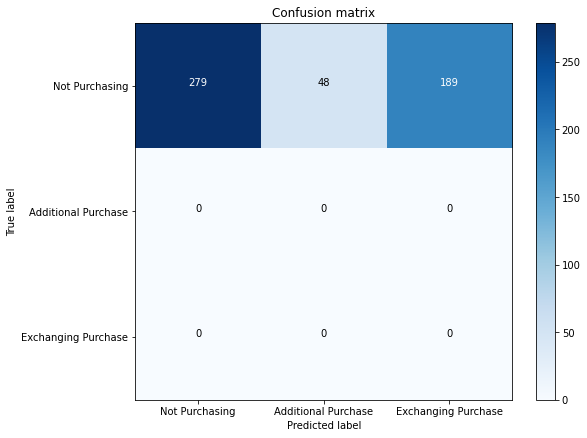

In [33]:
print(classification_report(y_test, y_pred, target_names=target_names,))
plot_confusion_matrix(y_test, y_pred, target_names=target_names, )